# 신용거래 이상탐지 데이터 다루기

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from math import radians, cos, sin, asin, sqrt

sns.set_context("notebook")


## 1) 데이터 로드

In [7]:
data_dir = "fraud.csv"
data = pd.read_csv(data_dir)

print("Shape:", data.shape)
display(data.head())


Shape: (200000, 10)


,trans_date_trans_time,customer_id,merchant_id,category,amt,lat,long,merch_lat,merch_long,is_fraud
0,2024-08-03 23:43:46,3780,63,entertainment,26.72,37.453855,127.437674,37.279472,127.282616,0
1,2024-10-10 07:48:02,2501,1157,grocery_pos,17.21,33.485412,128.356267,33.521803,128.598040,0
2,2024-08-04 05:58:20,2737,687,travel,150.46,34.912171,127.481025,35.139146,127.581664,0
3,2024-01-11 16:38:57,3589,917,travel,199.35,38.403931,126.512519,38.611619,126.098355,0
4,2024-02-07 22:17:43,2314,461,food_dining,43.65,35.410930,129.213600,35.342886,129.244315,0


## 2) 컬럼명 정리

In [8]:
data.columns = data.columns.str.lower().str.replace(" ", "_")
print("Columns:", list(data.columns)[:20], "..." if len(data.columns) > 20 else "")


Columns: ['trans_date_trans_time', 'customer_id', 'merchant_id', 'category', 'amt', 'lat', 'long', 'merch_lat', 'merch_long', 'is_fraud'] 


## 3) 불필요한 컬럼 제거

In [9]:
drop_candidates = [
    "first", "last", "street", "zip",
    "trans_num", "cc_num", "card_number",
    "unix_time", "job", "dob"
]

drop_cols = [c for c in drop_candidates if c in data.columns]
print("Dropping:", drop_cols)
data = data.drop(columns=drop_cols)

print("Shape after drop:", data.shape)


Dropping: []
Shape after drop: (200000, 10)


## 4) 결측치 처리

In [10]:
null_counts = data.isnull().sum().sort_values(ascending=False)
display(null_counts[null_counts > 0].head(30))


merch_lat     434
amt           409
category      385
merch_long    376
dtype: int64

In [11]:
num_cols = data.select_dtypes(include=np.number).columns.tolist()
cat_cols = data.select_dtypes(include="object").columns.tolist()

# 수치형 중앙값 대체
for col in num_cols:
    if data[col].isnull().any():
        data[col] = data[col].fillna(data[col].median())

# 범주형 최빈값 대체
for col in cat_cols:
    if data[col].isnull().any():
        data[col] = data[col].fillna(data[col].mode(dropna=True)[0])

# 확인
print("Remaining nulls:", int(data.isnull().sum().sum()))


Remaining nulls: 0


## 5) 이상치 처리 (거래금액 `amt` 기준)

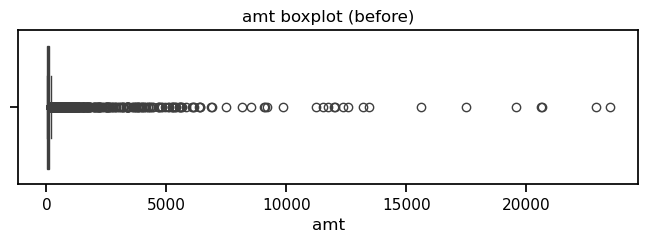

Filtered by IQR on amt: 200000 -> 184736


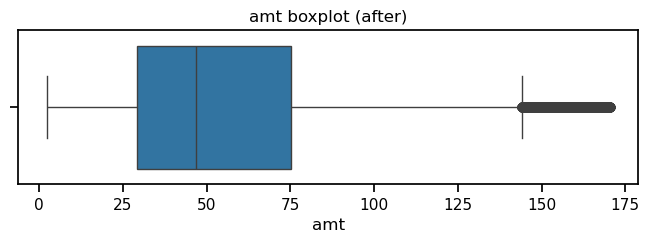

In [12]:
if "amt" in data.columns:
    plt.figure(figsize=(8, 2))
    sns.boxplot(x=data["amt"])
    plt.title("amt boxplot (before)")
    plt.show()

    Q1 = data["amt"].quantile(0.25)
    Q3 = data["amt"].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    before = len(data)
    data = data[(data["amt"] >= lower) & (data["amt"] <= upper)]
    after = len(data)

    print(f"Filtered by IQR on amt: {before} -> {after}")

    plt.figure(figsize=(8, 2))
    sns.boxplot(x=data["amt"])
    plt.title("amt boxplot (after)")
    plt.show()
else:
    print("No 'amt' column found. Skipping outlier handling.")


## 6) 피처 엔지니어링 (2개 이상 생성)
아래는 대표적으로 유용한 피처들입니다.

### (A) 시간 기반
- `trans_date_trans_time` → datetime 변환
- `hour`, `time_group` 생성

### (B) 고객별 평균 대비 금액 비율
- `amt_ratio` = `amt` / (고객별 평균 `amt`)

### (C) 거리 기반 (위도/경도)
- `distance_km` = 고객 위치(lat/long) ↔ 가맹점 위치(merch_lat/merch_long)

### (D) 고객별 일 거래 횟수
- `daily_txn_count`

In [13]:
# --- (A) 시간 기반 ---
time_col = None
for c in ["trans_date_trans_time", "transaction_time", "trans_time", "datetime"]:
    if c in data.columns:
        time_col = c
        break

if time_col:
    data[time_col] = pd.to_datetime(data[time_col], errors="coerce")
    # 혹시 변환 실패로 NaT가 생기면 최빈값/중앙값 대체 대신, 일단 제거
    data = data.dropna(subset=[time_col])

    data["hour"] = data[time_col].dt.hour

    def time_category(h):
        if 0 <= h < 6:
            return "late_night"
        elif 6 <= h < 12:
            return "morning"
        elif 12 <= h < 18:
            return "afternoon"
        else:
            return "evening"

    data["time_group"] = data["hour"].apply(time_category)
    data["date"] = data[time_col].dt.date
    print(f"Time features created from: {time_col}")
else:
    print("No datetime column found. Skipping time features.")


Time features created from: trans_date_trans_time


In [14]:
# --- (B) 고객별 평균 대비 금액 비율 ---
# 고객 식별 컬럼 후보
cust_col = None
for c in ["customer_id", "cust_id", "client_id"]:
    if c in data.columns:
        cust_col = c
        break

if ("amt" in data.columns) and cust_col:
    customer_mean_amt = data.groupby(cust_col)["amt"].transform("mean")
    data["amt_ratio"] = data["amt"] / customer_mean_amt.replace(0, np.nan)
    data["amt_ratio"] = data["amt_ratio"].fillna(0)
    print(f"amt_ratio created using '{cust_col}'")
else:
    print("Missing 'amt' or customer id column. Skipping amt_ratio.")


amt_ratio created using 'customer_id'


In [15]:
# --- (C) 거리 기반 (위도/경도) ---
geo_needed = ["lat", "long", "merch_lat", "merch_long"]
if all(c in data.columns for c in geo_needed):
    def haversine(lat1, lon1, lat2, lon2):
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * asin(sqrt(a))
        r = 6371  # km
        return c * r

    data["distance_km"] = data.apply(
        lambda row: haversine(row["lat"], row["long"], row["merch_lat"], row["merch_long"]),
        axis=1
    )
    print("distance_km created.")
else:
    print("Geo columns not complete. Skipping distance feature.")


distance_km created.


In [16]:
# --- (D) 고객별 일 거래 횟수 ---
if cust_col and ("date" in data.columns):
    data["daily_txn_count"] = data.groupby([cust_col, "date"])["date"].transform("count")
    print("daily_txn_count created.")
else:
    print("Missing customer id or date. Skipping daily_txn_count.")


daily_txn_count created.


## 7) 범주형 인코딩 (One-Hot)

In [17]:
target = "is_fraud"
if target not in data.columns:
    raise ValueError("Target column 'is_fraud' not found in dataset.")

# 타깃 분리
y = data[target].copy()
X = data.drop(columns=[target])

# 범주형 one-hot
X = pd.get_dummies(X, drop_first=True)

print("X shape:", X.shape)
print("y distribution:")
display(y.value_counts(normalize=True))


X shape: (184736, 390)
y distribution:


is_fraud
0    0.989325
1    0.010675
Name: proportion, dtype: float64

## 8) 최종 데이터 저장

In [19]:
import os

out_dir = os.path.join(os.getcwd(), "data")
os.makedirs(out_dir, exist_ok=True)

X_path = os.path.join(out_dir, "fraud_features_X.csv")
y_path = os.path.join(out_dir, "fraud_features_y.csv")

X.to_csv(X_path, index=False)
y.to_csv(y_path, index=False)

print("Saved:")
print(" -", X_path)
print(" -", y_path)


Saved:
 - c:\Users\ejh52\Desktop\공부\python\data\fraud_features_X.csv
 - c:\Users\ejh52\Desktop\공부\python\data\fraud_features_y.csv
